In [11]:
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
import pandas as pd
from PIL import Image, ImageDraw
from utils import custom_dataset
from torch.functional import F
from model import custom_model
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

# Variáveis

In [3]:
IMG_SIZE = 150
N_GRIDS = 5

transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

inv_transformer = transforms.Compose([
    transforms.Normalize(mean=(-1., -1., -1), std=(2., 2., 2.)),
    transforms.ToPILImage()
])

def collate_function(batch):
    
    imgs_tensor, bbox_tensor, target_tensor = [], [], []
    
    for annotations, img_path in batch:
        for annotation in annotations:
            img_pil, p_obj, bbox_obj, bbox_cell, target = annotation
            imgs_tensor.append(transformer(img_pil))
            bbox_tensor.append(bbox_obj)
            target_tensor.append(target)
    
    imgs_tensor = torch.stack(imgs_tensor)
    bbox_tensor = torch.tensor(bbox_tensor, dtype=torch.float)
    target_tensor = torch.tensor(target_tensor, dtype=torch.long)

    return imgs_tensor, bbox_tensor, target_tensor

# Criando modelo e realizando teste

imgs_tensor.shape=torch.Size([64, 3, 30, 30])


D:\Users\maraujo\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


output.shape=torch.Size([64, 7])
loss=tensor(1.3953, grad_fn=<AddBackward0>)


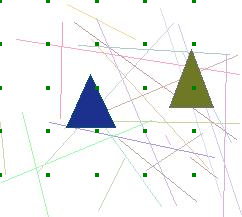

In [4]:
df = pd.read_csv('annotations.csv')
dataset = custom_dataset(df, IMG_SIZE=IMG_SIZE, N_GRIDS=N_GRIDS)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_function)
imgs_tensor, bbox_tensor, target_tensor = next(iter(dataloader))

print (f'{imgs_tensor.shape=}')

model = custom_model(imgs_tensor, 3, IMG_SIZE, N_GRIDS, transformer, inv_transformer)
output = model(imgs_tensor)
print (f'{output.shape=}')
loss = model.calculate_loss(output, bbox_tensor, target_tensor)
loss.backward()
print (f'{loss=}')

img_pil = Image.open('./imgs/img00001.jpg')
deteccoes = model.detect(img_pil, thresold=0.2)

draw = ImageDraw.Draw(img_pil)
for bbox, classe in deteccoes:
    cor = {0: 'red', 1: 'green'}
    draw.rectangle(bbox, fill=None, width=2, outline=cor[classe])

img_pil

# Preparando variáveis e funções úteis

In [37]:
IMG_SIZE = 150
N_GRIDS = 5
BATCH_SIZE = 32

df = pd.read_csv('annotations.csv')
df_train, df_test = train_test_split(df, test_size=0.1, stratify=df['tipo'])

df_train = pd.DataFrame(df_train.values, columns=df.columns) # se não fizer essas duas linhas o dataloader não funciona
df_test = pd.DataFrame(df_test.values, columns=df.columns) # se não fizer essas duas linhas o dataloader não funciona

print (f'{df.shape=}, {df_train.shape=}, {df_test.shape=}')

train_dataset = custom_dataset(df_train, IMG_SIZE=IMG_SIZE, N_GRIDS=N_GRIDS)
test_dataset = custom_dataset(df_test, IMG_SIZE=IMG_SIZE, N_GRIDS=N_GRIDS)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_function)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_function)

print (f'{len(train_dataloader)=}, {len(test_dataloader)=}')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print (f'{device=}')

model = custom_model(imgs_tensor, num_classes=3, IMG_SIZE=IMG_SIZE, N_GRIDS=N_GRIDS, transformer_=transformer, inv_transformer_=inv_transformer)
model.to(device)
print (f'Criando modelo e jogando para device.')

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print (f'Criando otimizador.')

def validate(dataloader_):
    model.eval()
    test_loss, n = 0, 0
    print ('Validação: ')
    with torch.no_grad():
        for imgs_tensor, bbox_tensor, target_tensor in tqdm(dataloader_):
            imgs_tensor, bbox_tensor, target_tensor = imgs_tensor.to(device), bbox_tensor.to(device), target_tensor.to(device)
            output = model(imgs_tensor)
            loss = model.calculate_loss(output, bbox_tensor, target_tensor)
            test_loss += loss.item()
            n += len(imgs_tensor)
    
    return test_loss/n

def deteccao_aleatoria():
    img_pil = Image.open(df_test.sample(1)['img_path'].values[0])

    deteccoes = model.detect(img_pil, thresold=0.7)

    draw = ImageDraw.Draw(img_pil)
    for bbox, classe in deteccoes:
        cor = {0: 'red', 1: 'green'}
        draw.rectangle(bbox, fill=None, width=2, outline=cor[classe])

    plt.figure(figsize=(10, 4))
    plt.title(f'threshold=0.7')
    plt.imshow(img_pil)
    plt.show()

test_loss = validate(test_dataloader)
print (f'Exemplo de resultado da função perda {test_loss=}')

log_dir = './logs/treinamento-01'
writer = SummaryWriter(log_dir=log_dir)
print (f'Preparando pasta para logs. {log_dir=}')

df.shape=(4000, 8), df_train.shape=(3600, 8), df_test.shape=(400, 8)
len(train_dataloader)=113, len(test_dataloader)=13
device=device(type='cpu')
Criando modelo e jogando para device.
Criando otimizador.
Validação: 


100%|██████████| 13/13 [00:02<00:00,  4.74it/s]

Exemplo de resultado da função perda test_loss=0.022547387455592382
Preparando pasta para logs. log_dir='./logs/treinamento-01'


# Treinamento

In [ ]:
model.train()

for epoch in range(20):

    clear_output(wait=True)
    print (f'{epoch=}')
    deteccao_aleatoria()

    with torch.set_grad_enabled(True):
        train_loss, n = 0, 0
        for imgs_tensor, bbox_tensor, target_tensor in tqdm(train_dataloader):
            imgs_tensor, bbox_tensor, target_tensor = imgs_tensor.to(device), bbox_tensor.to(device), target_tensor.to(device)

            model.zero_grad()
            output = model(imgs_tensor)
            loss = model.calculate_loss(output, bbox_tensor, target_tensor)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            n += len(imgs_tensor)
    
    test_loss = validate(test_dataloader)
    writer.add_scalar('train_loss', train_loss, epoch)
    writer.add_scalar('test_loss', test_loss, epoch)

print (f'Fim treinamento.')